## Setup

Import TensorFlow and other necessary libraries:

In [36]:
!pip install tensorflow==2.11
!pip install tensorflow-hub==0.12


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [38]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_root  = ('/content/drive/My Drive/data')
IMAGE_SHAPE = (425, 425)
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="validation",shuffle=True,target_size=(224, 224))
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="training",shuffle=True,target_size=(224, 224))

Mounted at /content/drive
Found 12 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [39]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

Here are some roses:

In [40]:
print (train_generator.class_indices)

{'needle': 0, 'not-needle': 1}


In [41]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

needle
not-needle

And some tulips:

In [42]:
import tensorflow_hub as hub
m = keras.Sequential([
    keras.layers.Resizing(224, 224),
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-classification/1"),  # Can be True, see below.
    keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
m.build([None, 425, 425, 3])  # Batch input shape.


In [43]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)
m.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

In [44]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = m.fit(
 train_generator,
 epochs=100,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/100
2/2 [==============================] - 13s 2s/step - loss: 1.0811 - acc: 0.4528 - val_loss: 0.5911 - val_acc: 0.6667
Epoch 2/100
2/2 [==============================] - 2s 994ms/step - loss: 0.4166 - acc: 0.8113 - val_loss: 0.3689 - val_acc: 0.6667
Epoch 3/100
2/2 [==============================] - 2s 772ms/step - loss: 0.2306 - acc: 0.8868 - val_loss: 0.2001 - val_acc: 1.0000
Epoch 4/100
2/2 [==============================] - 2s 753ms/step - loss: 0.1050 - acc: 0.9811 - val_loss: 0.0915 - val_acc: 1.0000
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.0439 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 1.0000
Epoch 6/100
2/2 [==============================] - 3s 2s/step - loss: 0.0224 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 8/100
2/2 [==============================] - 2s 1s/step - loss: 0.0073 - acc: 1.0000 - v

In [45]:
final_loss, final_accuracy = m.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

1/1 [==============================] - 0s 374ms/step - loss: 3.9664e-04 - acc: 1.0000
Final loss: 0.00
Final accuracy: 100.00%


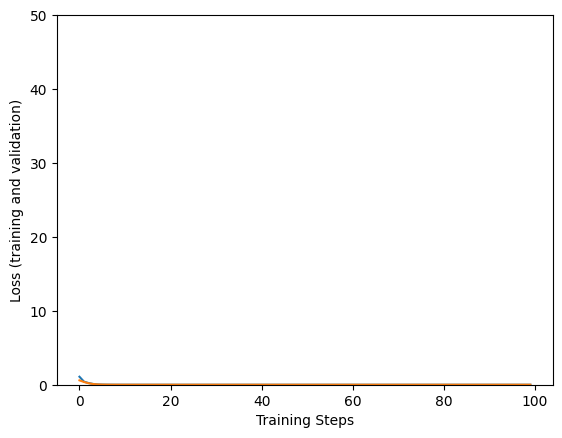

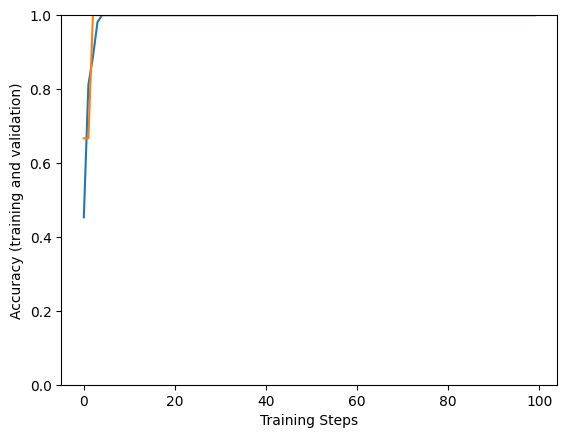

In [46]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

1/1 [==============================] - 1s 692ms/step
Prediction results shape: (12, 2)


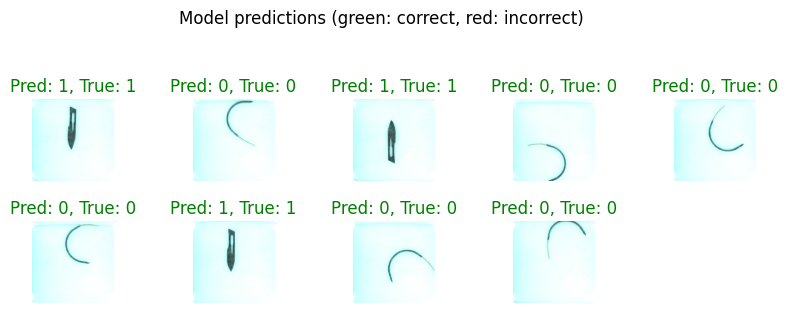

In [47]:
images, true_labels = next(valid_generator)

# Make predictions using the model
tf_model_predictions = m.predict(images)

print("Prediction results shape:", tf_model_predictions.shape)

# Set up the plot
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

# Iterate over the first few images and display them
for n in range(min(9, len(images))):  # Change 9 to however many images you want to display
    plt.subplot(6, 5, n + 1)  # Create a subplot grid (adjust if needed)
    plt.imshow(images[n])  # Display the image
    predicted_class = np.argmax(tf_model_predictions[n])  # Get the predicted class
    true_class = np.argmax(true_labels[n])  # Get the true class
    color = "green" if predicted_class == true_class else "red"
    plt.title(f"Pred: {predicted_class}, True: {true_class}", color=color)
    plt.axis('off')

# Add a super title to the plot
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [48]:
m.save('model/needle_or_not.h5')

In [50]:
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'KerasLayer': hub.KerasLayer})

loaded_model = tf.keras.models.load_model('model/needle_or_not.h5')

In [62]:
from tensorflow.keras.preprocessing import image

img_path = 'test/5.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

pred = loaded_model.predict(img_array)
predicted_class = "Needle"
if np.argmax(pred, axis=1) == 1 :
  predicted_class = "Not Needle"

print(f"Object is {predicted_class}")

1/1 [==============================] - 0s 85ms/step
Object is Not Needle
